<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_toam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=c40a212dfdea02443ff5b15b7b97d6696a3d73bbaf31fa493c8c35d1bbe270e7
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad


from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')

tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)
tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)
tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Voa vaovao (observed incidence)
Ivaotoa = tilyvoatoa['Voatomb']

dIvao = pd.DataFrame(data =Ivaotoa)

# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,5,27)
daty_data_mifar = datetime.date(2020,7,4)

datyt = daty_data_mifar 

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1, (t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1, k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)
# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(484.59858362846035, datetime.date(2020, 7, 3)), (491.0844763837328, datetime.date(2020, 7, 2)), (520.5482144320829, datetime.date(2020, 7, 1)), (590.1788864772388, datetime.date(2020, 6, 30)), (643.522738456101, datetime.date(2020, 6, 29)), (710.120501745874, datetime.date(2020, 6, 28)), (inf, datetime.date(2020, 6, 27)), (inf, datetime.date(2020, 6, 26)), (702.5320682311316, datetime.date(2020, 6, 25)), (inf, datetime.date(2020, 6, 24)), (inf, datetime.date(2020, 6, 23)), (inf, datetime.date(2020, 6, 22)), (inf, datetime.date(2020, 6, 21)), (inf, datetime.date(2020, 6, 20)), (inf, datetime.date(2020, 6, 19)), (inf, datetime.date(2020, 6, 18)), (inf, datetime.date(2020, 6, 17)), (inf, datetime.date(2020, 6, 16)), (inf, datetime.date(2020, 6, 15))]
Prt91 = [3.479438719517875e-211, 5.305444285440928e-214, 8.487560980196242e-227, 4.8816458250177354e-257, 3.3237297871965843e-280, 3.96811824762028e-309, 0.0, 0.0, 7.837894385769708e-306, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [572.4573546344915, 1223.9040989122223, 2016.9348262184917, 2926.4192768282114, 3859.678506293472, 4887.353827598146, 5906.507959223854]
APEk2 = [6.830163276061249, 15.255381673192673, 86.06642850883566, 147.76697906584013, 291.10111778162957, 418.5121642980251, 623.3158626632925]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [579.2875179105528, 1239.159480585415, 2103.0012547273273, 3074.1862558940516, 4150.779624075101, 5305.865991896171, 6529.823821887147]
APE = [579.2875179105528, 1239.159480585415, 2103.0012547273273, 3074.1862558940516, 4150.779624075101, 5305.865991896171, 6529.823821887147, inf]
2


# Fifidianana ireo taha mialoha (prior parameters)

In [ ]:
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


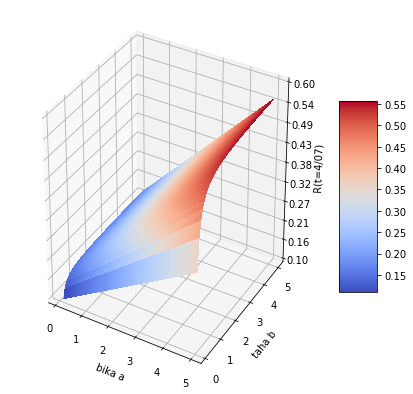

In [ ]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.1, 0.6)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=4/07)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt047_toam.eps')

plt.show()

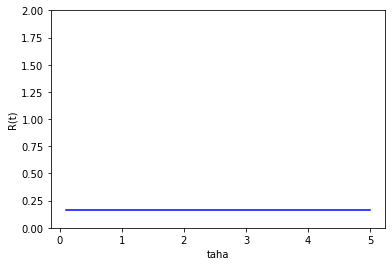

taha* = 1
R(t= 2020-07-04 ) = 0.16202738137537617 = bika*


In [ ]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


# Fanombanana ny R(t) (estimation of R(t))

### Fomba mahazatra

In [ ]:
# shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

# Rt
def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 75th and 25th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

daty_oh1 = datetime.date(2020,6,25)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))


print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))

Kajy mivantana ny R hoan'ny 2020-07-04 : 0.0
Salan'isa R hoan'ny 2020-06-25 : 0.1591312365857245
Kartily @ 75% R hoan'ny 2020-06-25 : 0.207112883992764
Kartily @ 25% R hoan'ny 2020-06-25 : 0.09337323880266504
Salan'isa R hoan'ny 2020-07-04 : 0.16202738131570996
Kartily @ 75% R hoan'ny 2020-07-04 : 0.2169786452287213
Kartily @ 25% R hoan'ny 2020-07-04 : 0.08103255395724786


In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -28)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +28)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(1000)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


### Fomba mifidy a sy b

In [ ]:
# Prior Gamma distribution of Rt

Rtpr_sh = 2.8 # shape
Rtpr_sc =  3 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,kk)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,kk))

# mean
def Rt_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

# 75th and 25th percentiles

def perc75(t):
  return gengamma.ppf(0.75, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc25(t):
  return gengamma.ppf(0.25, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))


def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)


daty_oh1 = datetime.date(2020,7,2)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))


print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))

Kajy mivantana ny R hoan'ny 2020-07-04 : 0.0
Salan'isa R hoan'ny 2020-07-02 : 0.17392084594405985
Kartily @ 75% R hoan'ny 2020-07-02 : 0.2284979287286213
Kartily @ 25% R hoan'ny 2020-07-02 : 0.0975145476170923
Salan'isa R hoan'ny 2020-07-04 : 0.37864068873949125
Kartily @ 75% R hoan'ny 2020-07-04 : 0.47668835569486556
Kartily @ 25% R hoan'ny 2020-07-04 : 0.25245640236950634


In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -28)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +28)
  data_amboar = [gengamma.rvs(Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t)) for j in range(1000)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


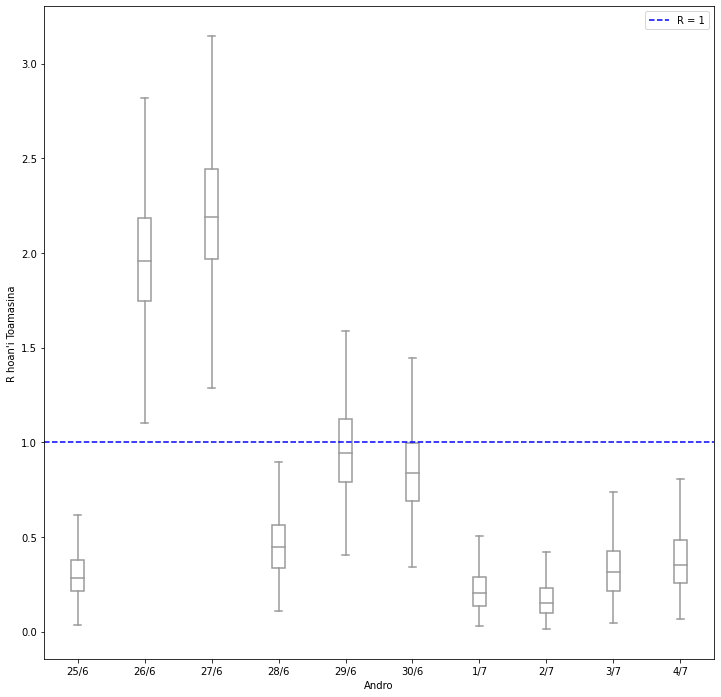

In [ ]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(12, 12))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt27547_toam.eps')
plt.savefig(path_to_save+'Rt27547_toam.png')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


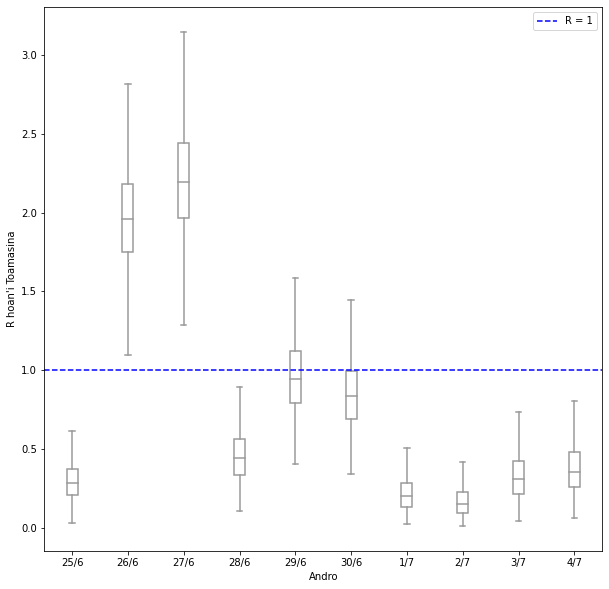

In [ ]:
# Plotting the last 10 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt2754710_toam.eps')
plt.savefig(path_to_save+'Rt2754710_toam.png')
plt.show()

# Jeritodika ny herinandro

In [ ]:
daty_ambaj = datetime.date(2020,6,25)
daty_amboj = datetime.date(2020,6,27)

daty_data_mifarj = datetime.date(2020,6,27)

In [ ]:
daty_oh1 = daty_ambaj

print("Tombana ambany: R ",daty_oh1,':',  Rt_salan(daty_oh1))
print("75%-kartily R :",':', perc75(daty_oh1))
print("25%-kartily R :", perc25(daty_oh1))

daty_oh2 = daty_amboj

print("Tombana ambony: R", daty_oh2,':', Rt_salan(daty_oh2))
print("75%-kartily R :",':', perc75(daty_oh2))
print("25%-kartily R :", perc25(daty_oh2))


Tombana ambany: R  2020-06-25 : 0.3023085318794021
75%-kartily R : : 0.37497492305472174
25%-kartily R : 0.2109877688058556
Tombana ambony: R 2020-06-27 : 2.2114523073797345
75%-kartily R : : 2.4452258665969846
25%-kartily R : 1.9558917203445716


### Ambany

In [ ]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_amba_hitsiny = 0
Rt_vinaj = Rt_salan(daty_ambaj) + Rt_amba_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [ ]:
# Plotting the evaluation of the last 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_baj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_baj.append(data_amboar)


### Ambony

In [ ]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_ambo_hitsiny = (Rt_salan(daty_ambaj) - Rt_salan(daty_amboj))/2
Rt_vinaj = Rt_salan(daty_amboj) + Rt_ambo_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [ ]:
Rt_vinaj

1.256737344851393

In [ ]:
# Plotting the evaluation of the last 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


### Sary

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


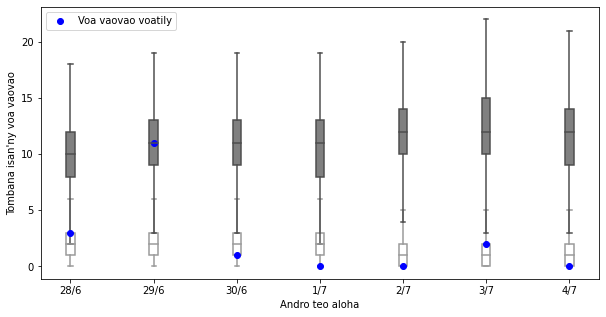

In [ ]:
# Plotting the evaluation of the last 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.1, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 6))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro teo aloha', ylabel="Tombana isan'ny voa vaovao")

plt.legend(loc= 'best')

plt.savefig(path_to_save+'Iv286j_toam.eps')
plt.savefig(path_to_save+'Iv286j_toam.png')

plt.show()

## Ny 7 andro manaraka

In [ ]:
daty_amba = datetime.date(2020,7,2)
daty_ambo = datetime.date(2020,6,29)


### Vinavina ambany

In [ ]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_amba)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_amba)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [ ]:
# Plotting boundaries for the next 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_amba_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_amba_hoav.append(data_amboar)

In [ ]:
print('Vinavina ambany')

daty_oh = datetime.date(2020,7,6)

print("Notombanana avy amin'ny R(", daty_amba, '):', Rt_salan(daty_amba)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao.loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

Vinavina ambany
Notombanana avy amin'ny R( 2020-07-02 ) 0.17392084594405985
Vinavina R hoan'ny 2020-07-06 : 0.3112930674809338
Vinavina kartily @ 75% R hoan'ny 2020-07-06 : 0.40897812312763593
Vinavina kartily @ 25% R hoan'ny 2020-07-06 : 0.17453688479357943
Vinavina isan'ny voa vaovao hoan'ny 2020-07-06 : Voatomb    0.0
Name: 2020-07-06 00:00:00, dtype: float64
Vinavina kartily @ 75% R hoan'ny 2020-07-06 : [0.]
Vinavina kartily @ 25% R hoan'ny 2020-07-06 : [0.]


### Vinavina ambony

In [ ]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_ambo)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_ambo)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [ ]:
# Plotting boundaries for the next 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_ambo_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_ambo_hoav.append(data_amboar)

In [ ]:
print('Vinavina ambony')

daty_oh = datetime.date(2020,7,6)

print("Notombanana avy amin'ny R(", daty_ambo, '):', Rt_salan(daty_ambo)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao.loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

Vinavina ambony
Notombanana avy amin'ny R( 2020-06-29 ) 0.9693195466369405
Vinavina R hoan'ny 2020-07-06 : 1.0716291389653394
Vinavina kartily @ 75% R hoan'ny 2020-07-06 : 1.278523887670054
Vinavina kartily @ 25% R hoan'ny 2020-07-06 : 0.8253463592889638
Vinavina isan'ny voa vaovao hoan'ny 2020-07-06 : Voatomb    3.0
Name: 2020-07-06 00:00:00, dtype: float64
Vinavina kartily @ 75% R hoan'ny 2020-07-06 : [6.]
Vinavina kartily @ 25% R hoan'ny 2020-07-06 : [2.]


### Sary

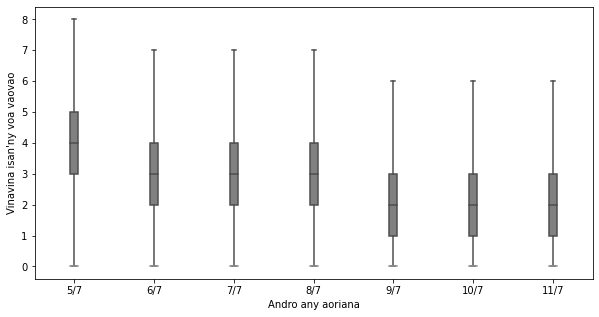

In [ ]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_hoav_lst, data_amba_hoav, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_hoav_lst, data_ambo_hoav, color='grey', width=0.1, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Iv47hoav_toam.eps')
plt.savefig(path_to_save+'Iv47hoav_toam.png')

plt.show()